In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

import string
import re

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout

In [24]:
# Check Python version
import sys
print("Python version")
print(sys.version)
print("Version info.")
print(sys.version_info)

# Check TensorFlow version
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

Python version
3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]
Version info.
sys.version_info(major=3, minor=11, micro=4, releaselevel='final', serial=0)
TensorFlow version: 2.15.0


In [2]:
#Data Processing

df = pd.read_csv('Dataset/Mental-Health-Twitter.csv')
df.head()

,Unnamed: 0,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label
0,0,637894677824413696,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed w...,1013187241,84,211,251,837,0,1
1,1,637890384576778240,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning t...",1013187241,84,211,251,837,1,1
2,2,637749345908051968,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain ...,1013187241,84,211,251,837,0,1
3,3,637696421077123073,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and...,1013187241,84,211,251,837,2,1
4,4,637696327485366272,Sat Aug 29 18:40:26 +0000 2015,It’s hard to say whether packing lists are mak...,1013187241,84,211,251,837,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    20000 non-null  int64 
 1   post_id       20000 non-null  int64 
 2   post_created  20000 non-null  object
 3   post_text     20000 non-null  object
 4   user_id       20000 non-null  int64 
 5   followers     20000 non-null  int64 
 6   friends       20000 non-null  int64 
 7   favourites    20000 non-null  int64 
 8   statuses      20000 non-null  int64 
 9   retweets      20000 non-null  int64 
 10  label         20000 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 1.7+ MB


In [4]:
# Drop unuse column
df = df[['post_text','label']]
df.head()

,post_text,label
0,It's just over 2 years since I was diagnosed w...,1
1,"It's Sunday, I need a break, so I'm planning t...",1
2,Awake but tired. I need to sleep but my brain ...,1
3,RT @SewHQ: #Retro bears make perfect gifts and...,1
4,It’s hard to say whether packing lists are mak...,1


In [5]:
# Initialize NLTK's objects for stemming and lemmatization
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Function to perform stemming, lemmatization, and remove stopwords
def preprocess_text(text):
    # Remove URLs, links, and punctuation
    text = re.sub(r'http\S+|www\S+|<.*?>', '', text)  # Remove URLs and links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\bRT\b|\bNT\b', '', text,flags=re.IGNORECASE)
    # Tokenize the text
    words = word_tokenize(text)

    # Perform stemming, lemmatization, and remove stopwords
    words = [stemmer.stem(lemmatizer.lemmatize(word)) for word in words if word.lower() not in stopwords.words('english')]

    return ' '.join(words)

In [7]:
# Apply the preprocessing function to the 'post_text' column
df['post_text'] = df.loc[:,'post_text'].apply(preprocess_text)


In [8]:
#Use back of word to show common words in post text
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt


# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the text data
X = vectorizer.fit_transform(df['post_text'])

# Get the count of each word
word_counts = X.toarray().sum(axis=0)

# Get the feature names (words)
words = vectorizer.get_feature_names_out()

In [9]:
# Create a dictionary with words and their counts
word_count_dict = dict(zip(words, word_counts))

# Sort the words by their counts to get the most common words
sorted_word_count = dict(sorted(word_count_dict.items(), key=lambda item: item[1], reverse=True))

# Select the top N words for visualization
top_n = 10
top_words = list(sorted_word_count.keys())[:top_n]
top_word_counts = list(sorted_word_count.values())[:top_n]


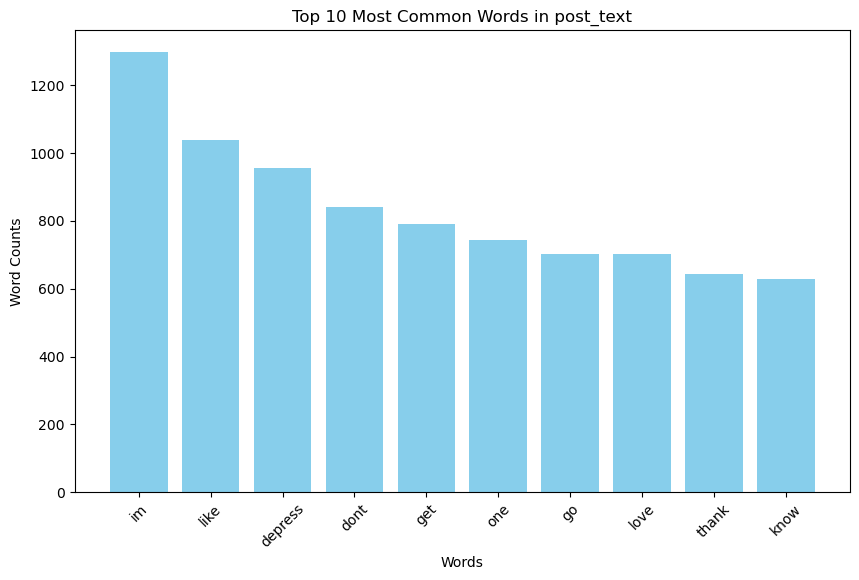

In [10]:
# Create a bar plot of the top N words
plt.figure(figsize=(10, 6))
plt.bar(top_words, top_word_counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Word Counts')
plt.title(f'Top {top_n} Most Common Words in post_text')
plt.xticks(rotation=45)
plt.show()

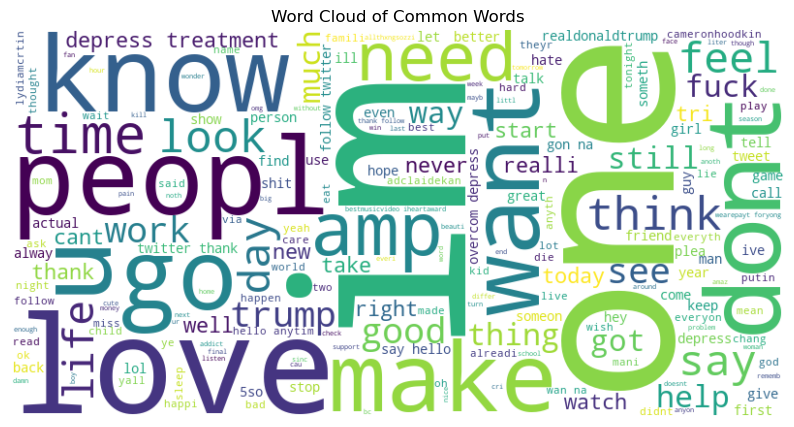

In [11]:
from wordcloud import WordCloud
# Concatenate all text into a single string
text = ' '.join(df['post_text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Common Words')
plt.show()

In [12]:
# Tokenizing and padding sequences
max_words = 1000
max_len = 100

In [13]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['post_text'])
sequences = tokenizer.texts_to_sequences(df['post_text'])
word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=max_len)

In [14]:
X = df['post_text']
y = df['label']

# Split the data into training and the rest (combining testing and validation first)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split the remaining data into testing and validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [15]:
# Tokenizing the text
max_words = 10000  # Consider only the top 10,000 words in the dataset
max_len = 100  # Limit each post to the first 100 words

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Creating the CNN-LSTM model
model = Sequential()
model.add(Embedding(max_words, 64, input_length=max_len))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test))




Epoch 1/10


188/188 [==============================] - 8s 26ms/step - loss: 0.5324 - accuracy: 0.7146 - val_loss: 0.3784 - val_accuracy: 0.8280
Epoch 2/10
188/188 [==============================] - 4s 22ms/step - loss: 0.2279 - accuracy: 0.9107 - val_loss: 0.3577 - val_accuracy: 0.8365
Epoch 3/10
188/188 [==============================] - 4s 21ms/step - loss: 0.1212 - accuracy: 0.9521 - val_loss: 0.3854 - val_accuracy: 0.8518
Epoch 4/10
188/188 [==============================] - 4s 24ms/step - loss: 0.0735 - accuracy: 0.9722 - val_loss: 0.4782 - val_accuracy: 0.8533
Epoch 5/10
188/188 [==============================] - 4s 21ms/step - loss: 0.0489 - accuracy: 0.9812 - val_loss: 0.5588 - val_accuracy: 0.8485
Epoch 6/10
188/188 [==============================] - 4s 21ms/step - loss: 0.0333 - accuracy: 0.9883 - val_loss: 0.6000 - val_accuracy: 0.8450
Epoch 7/10
188/188 [==============================] - 4s 20ms/step - loss: 0.0257 - accuracy: 0.9908 - val_loss: 0.6800 - val_accuracy: 0

In [16]:
# Assuming the model is already trained and you have X_test_pad and y_test

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_pad, y_test)

print(f"Test Accuracy: {accuracy * 100:.2f}%")

125/125 [==============================] - 1s 5ms/step - loss: 0.7595 - accuracy: 0.8493
Test Accuracy: 84.93%


In [17]:
# Single sentence for testing
sentence = "Feeling low today..."

# Tokenize and pad the single sentence
sequence = tokenizer.texts_to_sequences([sentence])
padded_sequence = pad_sequences(sequence, maxlen=max_len)

# Use the model to predict the sentiment
prediction = model.predict(padded_sequence)

# Classify the prediction (assuming binary classification)
sentiment = "Depressed" if prediction >= 0.5 else "Not Depressed"

print(f"The input sentence '{sentence}' is predicted as: {sentiment}")

1/1 [==============================] - 1s 558ms/step
The input sentence 'Feeling low today...' is predicted as: Depressed


In [18]:
# Single sentence for testing
sentence = "Im so mad at him. I dont want to meet him any more!!"

# Tokenize and pad the single sentence
sequence = tokenizer.texts_to_sequences([sentence])
padded_sequence = pad_sequences(sequence, maxlen=max_len)

# Use the model to predict the sentiment
prediction = model.predict(padded_sequence)

# Classify the prediction (assuming binary classification)
sentiment = "Depressed" if prediction >= 0.5 else "Not Depressed"

print(f"The input sentence '{sentence}' is predicted as: {sentiment}")

1/1 [==============================] - 0s 24ms/step
The input sentence 'Im so mad at him. I dont want to meet him any more!!' is predicted as: Not Depressed


In [19]:
# Single sentence for testing
sentence = "It's hard to get out of bed; everything feels overwhelming."

# Tokenize and pad the single sentence
sequence = tokenizer.texts_to_sequences([sentence])
padded_sequence = pad_sequences(sequence, maxlen=max_len)

# Use the model to predict the sentiment
prediction = model.predict(padded_sequence)

# Classify the prediction (assuming binary classification)
sentiment = "Depressed" if prediction >= 0.5 else "Not Depressed"

print(f"The input sentence '{sentence}' is predicted as: {sentiment}")

1/1 [==============================] - 0s 26ms/step
The input sentence 'It's hard to get out of bed; everything feels overwhelming.' is predicted as: Depressed


In [20]:
def predict_depression (sentence):
  # Tokenize and pad the single sentence
  sequence = tokenizer.texts_to_sequences([sentence])
  padded_sequence = pad_sequences(sequence, maxlen=max_len)

  # Use the model to predict the sentiment
  prediction = model.predict(padded_sequence)

  # Classify the prediction (assuming binary classification)
  sentiment = "Depressed" if prediction >= 0.5 else "Not Depressed"

  print(f"The input sentence '{sentence}' is predicted as: {sentiment}")

In [21]:
predict_depression("It's like I'm stuck in a deep, dark hole with no way out.")

1/1 [==============================] - 0s 28ms/step
The input sentence 'It's like I'm stuck in a deep, dark hole with no way out.' is predicted as: Not Depressed


In [22]:
predict_depression("I don't find joy in things I used to love.")

1/1 [==============================] - 0s 27ms/step
The input sentence 'I don't find joy in things I used to love.' is predicted as: Depressed


In [23]:
predict_depression("My thoughts are a maze, and I can't find my way out.")

1/1 [==============================] - 0s 29ms/step
The input sentence 'My thoughts are a maze, and I can't find my way out.' is predicted as: Depressed
